In [1]:
from google.colab import drive
drive.mount('./gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at ./gdrive


In [2]:
cd ./gdrive/My\ Drive/Colab Notebooks/Introspective-Neural-Networks-master

/content/gdrive/My Drive/Colab Notebooks/Introspective-Neural-Networks-master


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import torch

from torchvision.models import resnet18, vgg11
from tqdm.autonotebook import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import inspect
import time
from torch import nn, optim
import torch
import os
import numpy as np
import PIL.Image as Image
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, RandomResizedCrop, RandomCrop, RandomHorizontalFlip, ColorJitter
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from tqdm import tnrange, tqdm_notebook
from IPython.core.debugger import set_trace
from IPython.display import clear_output
from sklearn.metrics import confusion_matrix
from seaborn import heatmap

from utils import get_data_loaders, calculate_metric, print_scores

/usr/local/lib/python3.6/dist-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [0]:
def train(model, train_loader, val_loader, epochs=1, batch_size = 20):

    start_ts = time.time()
    
    train_loader = DataLoader(train_loader, batch_size = batch_size, shuffle = True)
    val_loader = DataLoader(val_loader, batch_size = batch_size, shuffle = True)

    losses = []
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), amsgrad=True)

    batches = len(train_loader)
    val_batches = len(val_loader)

    # training loop + eval loop
    stopping_criteria = False
    epoch = 0
    while (not stopping_criteria):
        total_loss = 0
        progress = tqdm(enumerate(train_loader), desc="Loss: ", total=batches)
        model.train()

        for i, data in progress:
            X, y = data[0].cuda(), data[1].cuda().squeeze(-1) 
            
            model.zero_grad()
            outputs = model.forward(X)

            loss = loss_function(outputs, y)

            loss.backward()
            optimizer.step()
            total_loss += loss.detach().item()
            progress.set_description("Loss: {:.4f}".format(loss.item()))

        torch.cuda.empty_cache()

        val_losses = 0
        precision, recall, f1, accuracy = [], [], [], []

        model.eval()
        with torch.no_grad():
            for i, data in enumerate(val_loader):
                X, y = data[0].cuda(), data[1].cuda().squeeze(-1) 
                
                outputs = model.forward(X)
                
                loss = loss_function(outputs, y)
                val_losses += loss.detach().item()

                predicted_classes = torch.argmax(outputs, 1).detach()

                for acc, metric in zip((precision, recall, f1, accuracy), 
                                       (precision_score, recall_score, f1_score, accuracy_score)):
                    acc.append(
                        calculate_metric(metric, y.detach().cpu(), predicted_classes.cpu())
                    )

        
        print(f"Epoch {epoch+1}/{epochs}, training loss: {total_loss/batches}, validation loss: {val_losses/val_batches}")
        print_scores(precision, recall, f1, accuracy, val_batches)
        losses.append(total_loss/batches)
        epoch += 1
        if sum(f1)/val_batches >= 0.99 or epoch > epochs:
            stopping_criteria = True
    pass

In [0]:
def plot_samples(dataset, t, l = 2, k = 2):
    '''
    Plot k x 2 grid with original and generated samples,
    chosenrandomly from the dataset
    dataset - torch.utils.data.Dataset with pos_imgs and pseudo_neg_imgs
    t - number of iteration
    l - len of the subsample of objects in dataset
    e.g. if l = 10, we randomly chose k generated from last ten pseudo_neg_imgs in dataset
    and ten original from first ten in pos_imgs
    k - number of plot pairs (orginal\generated)
    '''
  
    fig, axes = plt.subplots(nrows = k, ncols = 2)
    fig.suptitle('Iteration {}'.format(t), fontsize=10, color = 'b')
    
    l_pos = len(texture_dataset.pos_imgs)
    l_neg = len(texture_dataset.pseudo_neg_imgs)
    
    if k==1:
        axes = [axes]
    
    for ax, i_pos, i_neg  in zip(axes,
                                np.random.choice(range(l_pos), k, replace = False),
                                np.random.choice(range(1,l), k, replace = False)):
        
        im_pos = texture_dataset.pos_imgs[0]
        im_neg = texture_dataset.pseudo_neg_imgs[-i_neg]
        im_pos = im_pos.unsqueeze(0)
        im_neg = im_neg.unsqueeze(0)
        
        ax[0].imshow(deprocess(im_pos))
        ax[0].grid(False)
        ax[0].set_title('original')
        ax[1].imshow(deprocess(im_neg))
        ax[1].set_title('generated')
        ax[1].grid(False)
    
    plt.tight_layout()
    plt.savefig('./INN_texture_{}.jpg'.format(t))
    plt.show()

In [0]:
class TextureNet(nn.Module):
  
    '''
    Architecture of CNN proposed in https://arxiv.org/abs/1704.07820
    '''
  
    def __init__(self, mean = 0, std = 1):
        super(TextureNet, self).__init__()
        
        self.cn1 = nn.Conv2d(3, 64, kernel_size=(5,5))
        self.bn1 = nn.BatchNorm2d(64)
        
        self.cn2 = nn.Conv2d(64,128, kernel_size=(5,5))
        self.bn2 = nn.BatchNorm2d(128)
        
        self.cn3 = nn.Conv2d(128,256, kernel_size=(5,5))
        self.bn3 = nn.BatchNorm2d(256)

        self.cn4 = nn.Conv2d(256,512, kernel_size=(5,5))
        self.bn5 = nn.BatchNorm2d(512)
        
        self.cn5 = nn.Conv2d(512,1, kernel_size=(1,1))
        
        self.activation = nn.LeakyReLU(0.2)
        
        self.fc = torch.nn.Linear(256, 2);
        self.mp = nn.MaxPool2d((2,2))
        self.softmax = nn.Softmax()
        
        self.X = torch.nn.Parameter(torch.empty((1, 3, 32, 32)).data.normal_(mean, std))
        self.X.requires_grad = False;
        
    def to_synth(self, x):
      
        x = self.cn1(x)
        
        x = self.cn2(x) 
        x = self.bn2(x)
        x = self.activation(x)
        
        x = self.cn3(x) 
        x = self.bn3(x)
        x = self.activation(x)
        
        x = self.cn4(x) 
        x = self.bn5(x)
        x = self.activation(x)
        
        x = self.cn5(x)
        x = self.activation(x)
        
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        
        return x
    
    def forward(self, x):
        return self.to_synth(x)
      
      

In [0]:
def sample(module, iter_max=100, learning_rate=0.1, noise = 0.1, threshold = 0.9, iter_min = 10, add_noise=True):
  
    '''
    Performs sampling using Langevin dynamics
    module - trained CNN model
    '''
  
    assert isinstance(module.X, torch.nn.Parameter), 'Expected X to be an instance of torch.nn.Parameter';

    for name, param in module.named_parameters():
        if name != 'X':
            param.requires_grad = False;
        else:
            param.requires_grad = True;

    opt = torch.optim.Adam([module.X], lr=learning_rate, amsgrad=True);
    std_noise = learning_rate;

    i = 0
    stopping_criteria = False
    while (not stopping_criteria):

        opt.zero_grad();

        logit = -module.to_synth(module.X)
        classes = logit[0,0]

        classes.backward();

        if add_noise:
            module.X.grad += torch.empty_like(module.X.data).normal_(mean=0, std=noise);

        prob = nn.Sigmoid()(-classes).item()

        stopping_criteria = (prob >= threshold)

        opt.step()

        # normalize
        module.X.data -= module.X.data.min()
        module.X.data /= module.X.data.max()            

        i += 1
        if i >= iter_max:
            print ('NOT CONV', prob, i)
            break

    module.train(True);
    for name, param in module.named_parameters():
        if name != 'X':
            param.requires_grad = True;
        else:
            param.requires_grad = False;

    return module.X.data;

In [0]:
class TextureDataset(torch.utils.data.Dataset):
  
      def __init__(self, root_dir = '../static_textures', texture_names = ['clover'], train_size = 1000, training=True):
          self.root_dir = root_dir
          self.train_size = train_size
          self.pos_imgs = [];
          self.labels = [];
          self.textures = []
          self.pseudo_neg_imgs = []
          self.transformation = Compose([RandomCrop((32, 32)), RandomHorizontalFlip(), ToTensor() ])
          
          for texture_name in texture_names:
              path = os.path.join(root_dir, texture_name + '.jpg')
              img = Image.open(path)
              
              self.textures.append(img)
              
              for i in range(train_size):
                  
                  img_tensor = self.transformation(img)
                  self.pos_imgs.append(img_tensor.squeeze(0))
                  self.labels.append(torch.tensor([0]))

      def __getitem__(self, idx):
          
          self.imgs = self.pos_imgs + self.pseudo_neg_imgs
          x = self.imgs[idx];
          y = self.labels[idx];
        
          return x, y
        
      def __len__(self):
        
          return len(self.pos_imgs + self.pseudo_neg_imgs)
        
      def add_artificial(self, X):
          
          self.pseudo_neg_imgs.append(X.detach().cpu().squeeze(0));
          y = torch.tensor([1])
          self.labels.append(y);
        
        
def deprocess(img_tensor):

    img = img_tensor[0].detach().cpu().numpy().transpose(1,2,0)
    img = img.astype('float')

    return  img          

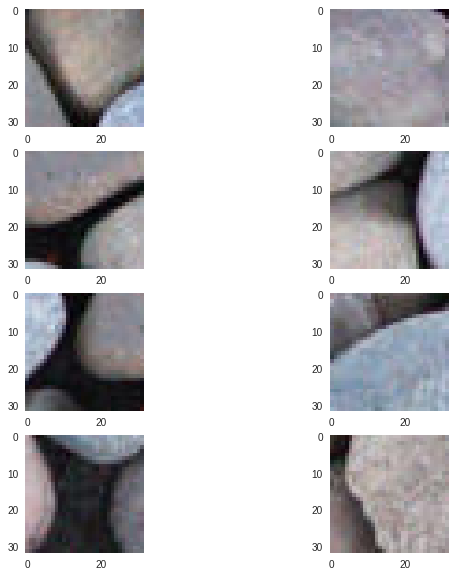

In [11]:
texture = 'stone'
texture_dataset = TextureDataset(texture_names = [texture], train_size = 1000)
model = TextureNet(mean, std).cuda()

#calculate mean, std in subsample original distribution
all_tensors = torch.cat([texture_dataset[indx][0] for indx in range(100)])
mean = all_tensors.mean().item()
std = all_tensors.std().item()


fig, axes = plt.subplots(ncols = 2, nrows=4, figsize = (10,10))
for i,ax in enumerate(axes.flatten()):
    
    im,y = texture_dataset[i]
    im = im.unsqueeze(0)
    img = deprocess(im)
    ax.imshow(img)
    ax.grid(False)

plt.show()

Synthesizing...
texture_dataset_len =  1200


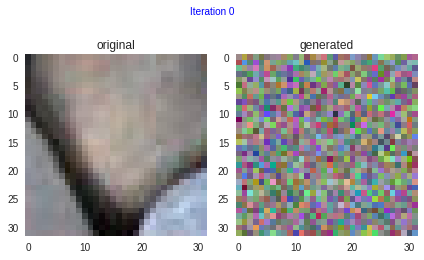

Epoch 1/20, training loss: 0.046314249294964076, validation loss: 9.076460659503937
	     precision: 0.4200
	        recall: 0.5000
	            F1: 0.4563
	      accuracy: 0.8400


Epoch 2/20, training loss: 0.01795133655747015, validation loss: 0.80886360257864
	     precision: 0.7159
	        recall: 0.8741
	            F1: 0.7271
	      accuracy: 0.7900


Epoch 3/20, training loss: 0.018286736401291016, validation loss: 0.3227302081650123
	     precision: 0.8147
	        recall: 0.9411
	            F1: 0.8441
	      accuracy: 0.9000


Epoch 4/20, training loss: 0.013169795945834588, validation loss: 0.05917410901747644
	     precision: 0.9358
	        recall: 0.9767
	            F1: 0.9539
	      accuracy: 0.9750


Epoch 5/20, training loss: 0.0016776580082745675, validation loss: 0.0036008817187394015
	     precision: 1.0000
	        recall: 1.0000
	            F1: 1.0000
	      accuracy: 1.0000
Synthesizing...
texture_dataset_len =  1200


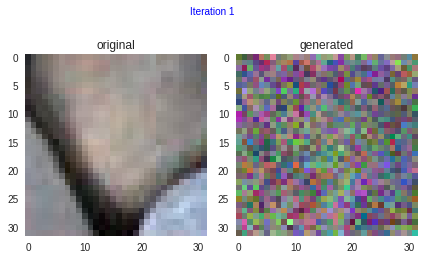

Epoch 1/20, training loss: 0.031026454578215422, validation loss: 4.386948645114899
	     precision: 0.6210
	        recall: 0.6662
	            F1: 0.4372
	      accuracy: 0.4525


Epoch 2/20, training loss: 0.012188793588018812, validation loss: 3.994945853948593
	     precision: 0.4213
	        recall: 0.5000
	            F1: 0.4566
	      accuracy: 0.8425


Epoch 3/20, training loss: 0.003521426676717751, validation loss: 0.08524472254794091
	     precision: 0.9857
	        recall: 0.9254
	            F1: 0.9482
	      accuracy: 0.9750


Epoch 4/20, training loss: 0.0011354786464139847, validation loss: 2.9088325798511505
	     precision: 0.6452
	        recall: 0.7340
	            F1: 0.5358
	      accuracy: 0.5650


Epoch 5/20, training loss: 0.0017251007700585486, validation loss: 0.1365639533905778
	     precision: 0.9852
	        recall: 0.9288
	            F1: 0.9513
	      accuracy: 0.9750


Epoch 6/20, training loss: 0.005409851899136864, validation loss: 0.5185463726520538
	     precision: 0.7493
	        recall: 0.7216
	            F1: 0.7267
	      accuracy: 0.8575


Epoch 7/20, training loss: 0.0012186498363278401, validation loss: 0.9851042926311493
	     precision: 0.7080
	        recall: 0.8562
	            F1: 0.7056
	      accuracy: 0.7600


Epoch 8/20, training loss: 0.00203634164871774, validation loss: 4.85756528377533
	     precision: 0.4888
	        recall: 0.5625
	            F1: 0.5215
	      accuracy: 0.8525


Epoch 9/20, training loss: 0.01381053973626181, validation loss: 0.02180187526391819
	     precision: 0.9940
	        recall: 0.9724
	            F1: 0.9824
	      accuracy: 0.9900


Epoch 10/20, training loss: 0.0005167187009647023, validation loss: 1.3420137092471123
	     precision: 0.6982
	        recall: 0.8411
	            F1: 0.6818
	      accuracy: 0.7350


Epoch 11/20, training loss: 0.00018957306378176916, validation loss: 0.001593847399817605
	     precision: 1.0000
	        recall: 1.0000
	            F1: 1.0000
	      accuracy: 1.0000
Synthesizing...
texture_dataset_len =  1200


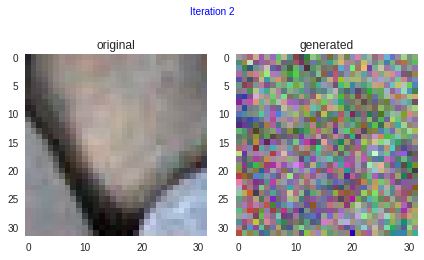

Epoch 1/20, training loss: 0.043462753783966065, validation loss: 11.216733753681183
	     precision: 0.4063
	        recall: 0.5000
	            F1: 0.4473
	      accuracy: 0.8125


Epoch 2/20, training loss: 0.019410851269426262, validation loss: 2.081076681613922
	     precision: 0.4106
	        recall: 0.4955
	            F1: 0.4489
	      accuracy: 0.8150


Epoch 3/20, training loss: 0.003656980524015928, validation loss: 3.0289512425661087
	     precision: 0.4112
	        recall: 0.5000
	            F1: 0.4504
	      accuracy: 0.8225


Epoch 4/20, training loss: 0.0014661792064383488, validation loss: 1.1563843041658401
	     precision: 0.5283
	        recall: 0.5139
	            F1: 0.4703
	      accuracy: 0.8075


Epoch 5/20, training loss: 0.01024282819879077, validation loss: 4.446115642786026
	     precision: 0.4112
	        recall: 0.5000
	            F1: 0.4510
	      accuracy: 0.8225


Epoch 6/20, training loss: 0.003997869834540111, validation loss: 0.12892568251118064
	     precision: 0.9758
	        recall: 0.8891
	            F1: 0.9189
	      accuracy: 0.9575


Epoch 7/20, training loss: 0.00020007456334817964, validation loss: 0.016768366813721514
	     precision: 0.9852
	        recall: 0.9971
	            F1: 0.9907
	      accuracy: 0.9950
Synthesizing...
texture_dataset_len =  1200


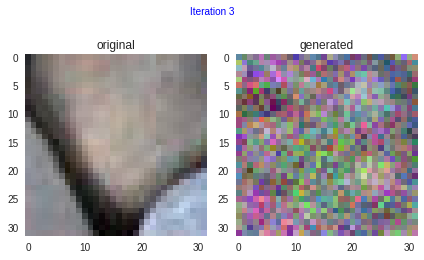

Epoch 1/20, training loss: 0.009295395209081188, validation loss: 3.077362298965454
	     precision: 0.9056
	        recall: 0.7107
	            F1: 0.7432
	      accuracy: 0.8975


Epoch 2/20, training loss: 0.004269104509110189, validation loss: 0.3035357367261895
	     precision: 0.9685
	        recall: 0.8215
	            F1: 0.8659
	      accuracy: 0.9425


Epoch 3/20, training loss: 7.386060220055162e-05, validation loss: 0.005708116143978259
	     precision: 0.9970
	        recall: 0.9875
	            F1: 0.9915
	      accuracy: 0.9950
Synthesizing...
texture_dataset_len =  1200


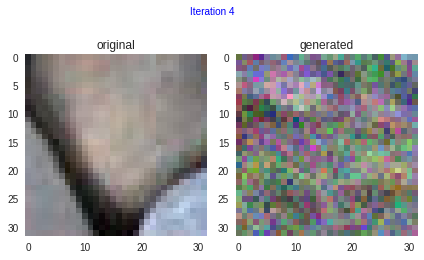

Epoch 1/20, training loss: 0.03311499341197736, validation loss: 8.533234298229218
	     precision: 0.4150
	        recall: 0.4129
	            F1: 0.4137
	      accuracy: 0.6875


Epoch 2/20, training loss: 0.008618923729182375, validation loss: 1.6734348088502884
	     precision: 0.6736
	        recall: 0.8300
	            F1: 0.6671
	      accuracy: 0.7400


Epoch 3/20, training loss: 0.0007282517746335436, validation loss: 0.03828876585146901
	     precision: 0.9985
	        recall: 0.9931
	            F1: 0.9956
	      accuracy: 0.9975
Synthesizing...
texture_dataset_len =  1200


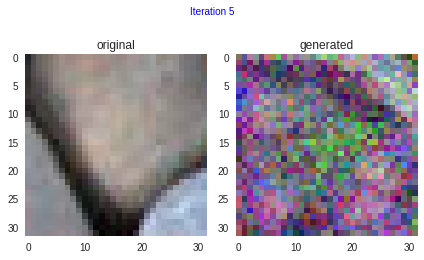

Epoch 1/20, training loss: 5.553511937020851e-05, validation loss: 2.8198321908712387
	     precision: 0.7143
	        recall: 0.8760
	            F1: 0.7217
	      accuracy: 0.7875


Epoch 2/20, training loss: 0.0011234739734968672, validation loss: 1.3950611129403114
	     precision: 0.7711
	        recall: 0.9166
	            F1: 0.8036
	      accuracy: 0.8600


Epoch 3/20, training loss: 0.007733985368504899, validation loss: 6.482314258813858
	     precision: 0.4263
	        recall: 0.5000
	            F1: 0.4599
	      accuracy: 0.8525


Epoch 4/20, training loss: 0.0020798613919940285, validation loss: 0.17997279175324365
	     precision: 0.9834
	        recall: 0.9018
	            F1: 0.9304
	      accuracy: 0.9700


Epoch 5/20, training loss: 0.015002898783158655, validation loss: 22.69113540649414
	     precision: 0.6094
	        recall: 0.6440
	            F1: 0.3999
	      accuracy: 0.4075


Epoch 6/20, training loss: 0.013445627860274393, validation loss: 6.017295449972153
	     precision: 0.4898
	        recall: 0.5062
	            F1: 0.4718
	      accuracy: 0.8550


Epoch 7/20, training loss: 0.002375680011109647, validation loss: 14.233420014381409
	     precision: 0.6139
	        recall: 0.6454
	            F1: 0.3985
	      accuracy: 0.4050


Epoch 8/20, training loss: 4.151288160284473e-08, validation loss: 4.8004783391952515
	     precision: 0.6240
	        recall: 0.7390
	            F1: 0.5201
	      accuracy: 0.5550


Epoch 9/20, training loss: 1.516061665227272e-07, validation loss: 0.029419790302199544
	     precision: 0.9812
	        recall: 0.9955
	            F1: 0.9875
	      accuracy: 0.9925


Epoch 10/20, training loss: 0.00029395597486114866, validation loss: 0.20529024475854385
	     precision: 0.9942
	        recall: 0.9685
	            F1: 0.9802
	      accuracy: 0.9900


Epoch 11/20, training loss: 0.00023035441530418118, validation loss: 2.7616755664348602
	     precision: 0.6551
	        recall: 0.7589
	            F1: 0.6148
	      accuracy: 0.6875


Epoch 12/20, training loss: 1.1781664490229105e-05, validation loss: 0.013368950787111089
	     precision: 0.9859
	        recall: 0.9970
	            F1: 0.9910
	      accuracy: 0.9950
Synthesizing...
texture_dataset_len =  1200


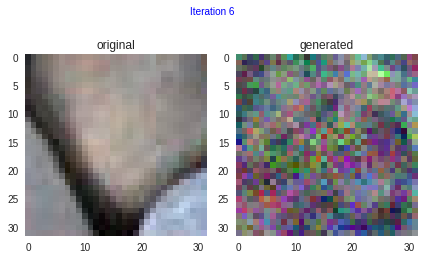

Epoch 1/20, training loss: 1.5033343235787096e-05, validation loss: 0.07752011448132468
	     precision: 0.9982
	        recall: 0.9961
	            F1: 0.9971
	      accuracy: 0.9975
Synthesizing...
texture_dataset_len =  1200


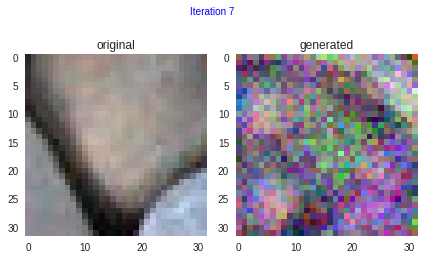

Epoch 1/20, training loss: 0.00871546807538034, validation loss: 0.6683676391839981
	     precision: 0.7990
	        recall: 0.8841
	            F1: 0.8271
	      accuracy: 0.9000


Epoch 2/20, training loss: 2.533758394019468e-05, validation loss: 7.172163546085358
	     precision: 0.6390
	        recall: 0.7699
	            F1: 0.5717
	      accuracy: 0.6200


Epoch 3/20, training loss: 0.02082438399939037, validation loss: 1.3729372434318066
	     precision: 0.8753
	        recall: 0.6934
	            F1: 0.7364
	      accuracy: 0.9100


Epoch 4/20, training loss: 0.001769101799413018, validation loss: 0.024478159027637503
	     precision: 0.9985
	        recall: 0.9931
	            F1: 0.9956
	      accuracy: 0.9975
Synthesizing...
texture_dataset_len =  1200


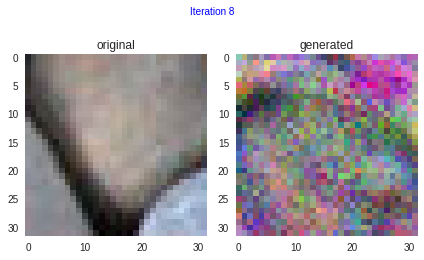

Epoch 1/20, training loss: 0.00888980046940624, validation loss: 25.541341066360474
	     precision: 0.6103
	        recall: 0.6986
	            F1: 0.4599
	      accuracy: 0.4875


Epoch 2/20, training loss: 0.0700772793889627, validation loss: 0.9420670010149479
	     precision: 0.9361
	        recall: 0.7040
	            F1: 0.7437
	      accuracy: 0.8825


Epoch 3/20, training loss: 0.004466049238342569, validation loss: 24.31309676170349
	     precision: 0.5911
	        recall: 0.5814
	            F1: 0.2933
	      accuracy: 0.2950


Epoch 4/20, training loss: 0.007132559219402544, validation loss: 12.689265608787537
	     precision: 0.6035
	        recall: 0.6300
	            F1: 0.4408
	      accuracy: 0.4675


Epoch 5/20, training loss: 0.0021872950219275194, validation loss: 15.108229041099548
	     precision: 0.6023
	        recall: 0.6667
	            F1: 0.4167
	      accuracy: 0.4325


Epoch 6/20, training loss: 0.0069327556568407256, validation loss: 8.230024665594101
	     precision: 0.4263
	        recall: 0.5000
	            F1: 0.4599
	      accuracy: 0.8525


Epoch 7/20, training loss: 0.0007849647931964717, validation loss: 0.011448849550902196
	     precision: 0.9958
	        recall: 0.9719
	            F1: 0.9820
	      accuracy: 0.9925


Epoch 8/20, training loss: 0.00012290632178093956, validation loss: 0.0034372996635039232
	     precision: 0.9938
	        recall: 0.9985
	            F1: 0.9959
	      accuracy: 0.9975
Synthesizing...
texture_dataset_len =  1200


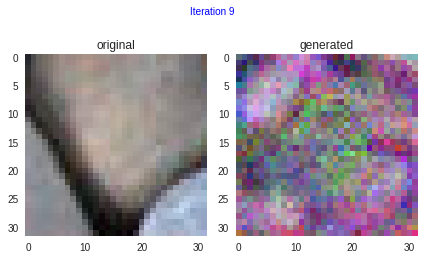

Epoch 1/20, training loss: 0.0344452402926981, validation loss: 20.42030680179596
	     precision: 0.5918
	        recall: 0.5586
	            F1: 0.3421
	      accuracy: 0.3475


Epoch 2/20, training loss: 0.0002931611375587676, validation loss: 10.069206178188324
	     precision: 0.6285
	        recall: 0.7127
	            F1: 0.4963
	      accuracy: 0.5175


Epoch 3/20, training loss: 0.0001771677209550613, validation loss: 0.15503894400549711
	     precision: 0.8834
	        recall: 0.9685
	            F1: 0.9131
	      accuracy: 0.9475


Epoch 4/20, training loss: 0.01045783974450544, validation loss: 12.695920944213867
	     precision: 0.4477
	        recall: 0.4479
	            F1: 0.1446
	      accuracy: 0.1600


Epoch 5/20, training loss: 0.005521275764370076, validation loss: 6.248617053031921
	     precision: 0.6187
	        recall: 0.6695
	            F1: 0.5009
	      accuracy: 0.5400


Epoch 6/20, training loss: 0.0021370430172115607, validation loss: 0.010673345769905751
	     precision: 0.9777
	        recall: 0.9955
	            F1: 0.9858
	      accuracy: 0.9925


Epoch 7/20, training loss: 0.00040214705639422566, validation loss: 0.0003314721579954494
	     precision: 1.0000
	        recall: 1.0000
	            F1: 1.0000
	      accuracy: 1.0000


In [16]:
from warnings import filterwarnings
filterwarnings('ignore')

l = 200 # how many pseudo-negative samples we add ti the dataset at each iteration
T = 10 # number of iteration
freq = T // 2

for t in tqdm_notebook(range(T)):
    
    augs = [] #  pseudo-negative samples
    print ('Synthesizing...')
    for i in range(l):
        if t == 0:
            aug = torch.empty(model.X.data.shape).data.normal_(mean, std)
        else:
            c = np.random.choice(range(1,l), 1, replace = False)[0]
            model.X.data = texture_dataset.pseudo_neg_imgs[-c].unsqueeze(0).cuda() # randomly initialize x from pos-neg dist
            aug = sample(model, iter_max = 50, learning_rate=0.05, add_noise=False);
        
        # normalization
        aug -= aug.min();
        aug /= aug.max();
        augs.append(aug)   
    
    # augmentation
    texture_dataset.pseudo_neg_imgs = []
    for aug in augs:
        texture_dataset.add_artificial(aug);
    print ('texture_dataset_len = ', len(texture_dataset))
    
    # plot&save random pseudo-negative samples
    plot_samples(texture_dataset, t, l = l,  k = 1)
    img = (deprocess(aug))
    plt.imsave('./INN_texture_{}.jpg'.format(t), img)
    
    
    # save dataset
    if T % freq == 0:
        torch.save(texture_dataset, './dataset_{0}_{1}.pt'.format(texture, t))
    
    test_size = int(0.3*len(texture_dataset))
    train_loader, val_loader = torch.utils.data.random_split(texture_dataset, [len(texture_dataset) - test_size, test_size ])
    
    train(model, train_loader, val_loader, epochs= 20, batch_size = 50);    